In [37]:
using Graphs
using RNAStructPlot
using CairoMakie

sequence = "AACGCUUCAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUAA"
notation = "..(((((((..((((((.........))))))......).((((((.......))))))..)))))).."

# sequence = "AAAAAAAAAAAAAAAAAA"
# notation = ".((.((((..)).))))."

"..(((((((..((((((.........))))))......).((((((.......))))))..)))))).."

In [118]:
"""
RegularPolygon

a(TYPEDFIELDS)
"""
struct RegularPolygon
    "radius of the polygon circle"
    radius::Float64
    "amount of points"
    n::Int64
    "center of polygon"
    center::Vector{Float64}
    "rotation of the polygon"
    rotation::Float64
end

"""
a(SIGNATURES)

Constructs a `RegularPolygon` with side lengths of 1 unit.
"""
function RegularPolygonSides(n::Int, center::Vector{Float64}=[0.0,0.0], rotation::Float64=0.0, sides::Float64=1.0)::RegularPolygon
    radius = sides/(2*sin(pi/n))
    return RegularPolygon(radius, n, center, rotation)
end

RegularPolygonSides

In [114]:
"""
a(SIGNATURES)

Gets an ordered list of points for the polygon.
"""
function points(polygon::RegularPolygon)::Vector{Vector{Float64}}
    segmentsize = 2*pi/polygon.n
    p = []
    for i=0:(polygon.n-1)
        # caculate angle of point relative to center
        current = segmentsize*i+polygon.rotation
        # convert polar to cartesian coordinates, since radius and angle are known
        px, py = polygon.radius .* [cos(current), sin(current)]
        # append absolute position by adding center coordinates
        push!(p, [px, py]+polygon.center)
    end
    return p
end

function find_pairing((p1, p2), pairings)
    for (k, v) in pairings
        if (p1, p2) in v
            return k, v
        end
    end
    return missing
end

normalizeangle(θ) = θ < 0 ? θ + 2*pi : θ

normalizeangle (generic function with 1 method)

In [133]:
using LinearAlgebra

function drawpolygonal(rnatree::RNATreeGraph, rnabase::RNABaseGraph)

    sidelength = 1.0
    stemlength = sidelength/2

    loops = sort(map(sort, collect(values(rnatree.loopbases)));by=minimum)
    stem = rnatree.regionpairs

    coords = Dict()
    numberings = Dict(v => [0.0,0.0] for v in vertices(rnabase.graph))
    start = minimum(vertices(rnatree.graph))

    function layoutloop(treevertex, polygon)
        loop = loops[treevertex]
        loopsize = length(loop)
        polygonpoints = points(polygon)

        # set base pair in loop to corner in polygon
        for (i, v) in enumerate(loop)
            coords[v] = polygonpoints[i]
            numberings[v] = coords[v] + normalize(coords[v] - polygon.center)*0.5
        end

        # loop through possible pairs attached to loop 
        for i in range(0, loopsize-1)
            current = loop[i%loopsize+1]
            next = loop[(i+1)%loopsize+1]

            # check if pair is the beginning of region stem, if yes draw it
            if hasexactpair(rnatree, current, next)
                (from, to), stempairs = find_pairing((current, next), stem)
                layoutstem(from, to, current, next, stempairs, polygon)
            end
        end
    end

    function layoutstem(fromvertex, tovertex, current, next, stempairs, frompolygon)
        middle = coords[current]+(coords[next]-coords[current])/2
        direction = normalize(middle - frompolygon.center)*stemlength

        # walk along region stempairs and calculate their positions
        for (i, (low, high)) in enumerate(stempairs)
            coords[low]  = coords[current] + direction*(i-1)
            coords[high] = coords[next] + direction*(i-1)

            numberings[high] = coords[high] + (coords[high] - coords[low])/2
            numberings[low] = coords[low] + (coords[low] - coords[high])/2
        end

        # prepare next loop attached to region stem
        toloop = loops[tovertex]
        toloopsize = length(toloop)

        # calculate dimension of polygon
        alpha = 2*pi/toloopsize
        tomid = middle + direction*(length(stempairs)-1)
        toscale = sidelength/(2*tan(alpha/2))
        tocenter = tomid + toscale*normalize(tomid - frompolygon.center)

        # determine starting angle
        ox, oy = coords[last(stempairs)[1]] .- tocenter
        torotation = normalizeangle(atan(oy, ox))

        topolygon = RegularPolygonSides(toloopsize, tocenter, torotation, sidelength)

        # recursively go down to next subtree
        layoutloop(tovertex, topolygon)
    end

    layoutloop(start, RegularPolygonSides(length(loops[start]), [0.,0.], 0. , sidelength))
    return DrawResult(coords, numberings)
end

drawpolygonal (generic function with 2 methods)

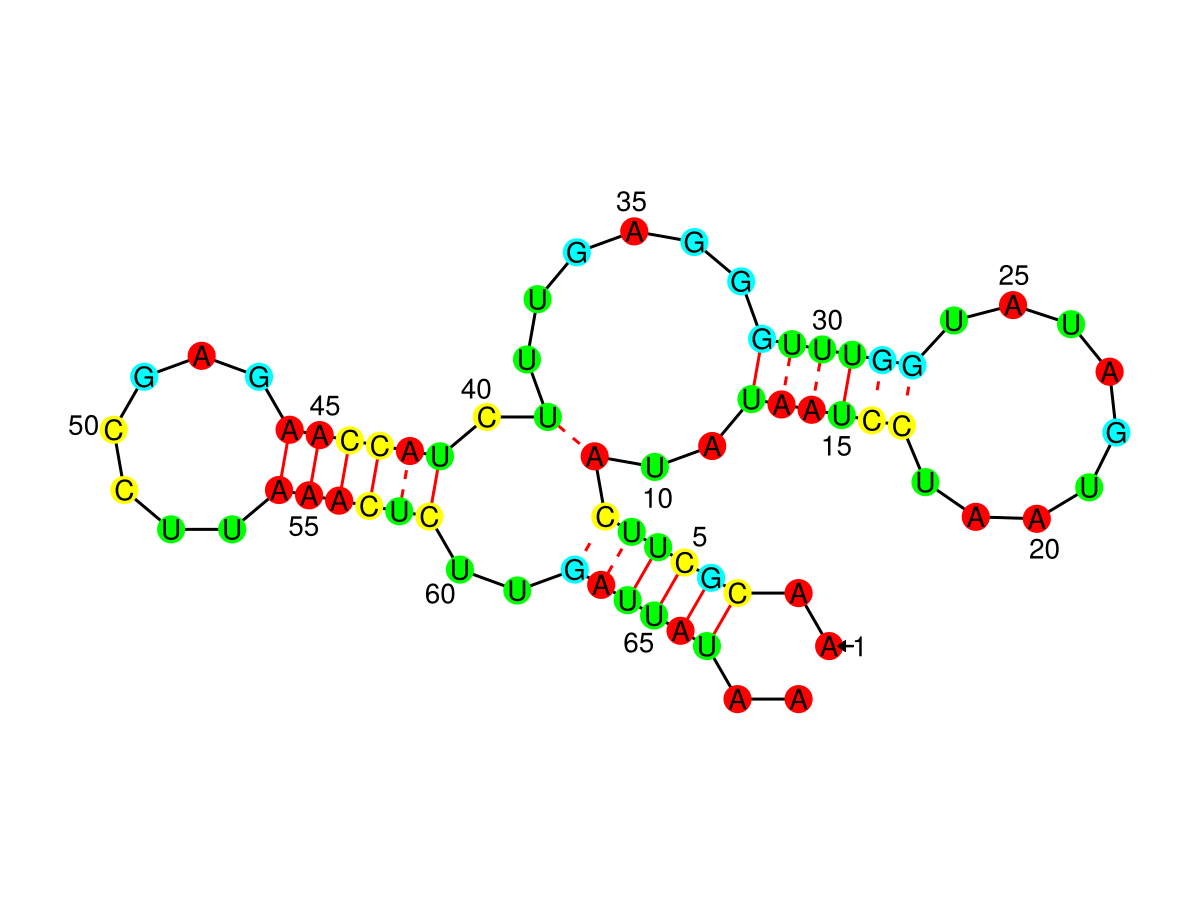

In [134]:
using RNAStructPlot

rnatree = dotbrackettree(sequence, notation)
rnabase = dotbracketbase(sequence, notation)

result = drawpolygonal(rnatree, rnabase)

drawgeneric(rnabase, result)